In [1]:
#  K-anonymisation sur la base "Transparence Santé" - Avantages (k=5)

## I. Nettoyage de la base de données

In [2]:
%matplotlib inline

In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

from anonymizer.import_insee import (expand_insee,
                                     nbre_modif)

from anonymizer.anonymity import (get_k, get_anonymities, 
                                  less_anonym_groups,
                                  local_aggregation,
                                  _local_aggregate_one_var)
from anonymizer.diversity import (get_l, 
                                  get_diversities, 
                                  diversity_distribution,
                                  less_diverse_groups
                                )
from anonymizer.transformations import (first_letters)
from anonymizer.transformations import str_drop
from anonymizer.anonymDF import AnonymDataFrame

In [4]:
# Importation des 50 000 premières lignes

chemin = "C:/Users/Pierre-Louis/declaration_avantage_2016_06_06_04_00.csv"

nbre_lignes = 50000
avantages = pd.read_csv(chemin, sep = ";", nrows = nbre_lignes, low_memory = False)

In [5]:
# Quelques petites transformations préalables

# On transforme les CP en indicateurs régionaux
avantages['benef_dept'] = first_letters(avantages['benef_codepostal'],2)
avantages['benef_etablissement_dept'] = first_letters(avantages['benef_etablissement_codepostal'],2)

# On supprime les CP peu orthodoxes
erreur_CP = ['0', '', 'IN']
avantages.loc[avantages['benef_dept'].isin(erreur_CP), 'benef_dept'] = np.nan
erreur_pays = ['[RE]','[GP]']
avantages.loc[avantages['benef_pays_code'].isin(erreur_pays), 'benef_pays_code'] = '[FR]'

# On remplace les "Nan" par "non-renseigné"
avantages = avantages.fillna('non renseigné')
to_replace = ['[AUTRE]', '']
avantages.replace(to_replace, 'non renseigné', inplace=True)


# On supprime d'abord les variables identifiantes afin de ne garder que les variables quasi-identifiantes

variables_supprimees = ['avant_convention_lie', # nom de code de la convention
                        'identifiant_type', # on garde la valeur 
                        'benef_qualification', # champ libre on ne garde que benef_specialite et qualite
                        'benef_speicalite_libelle', #
                        'ligne_rectification',
                        'denomination_sociale',
                        'benef_titre_libelle',
                        'pays',
                        'benef_prenom', # identifiant
                        'benef_nom', # identifiant
                        'benef_adresse1', # identifiant
                        'benef_adresse2', # identifiant
                        'benef_adresse3',# identifiant
                        'benef_adresse4',# identifiant
                        'benef_identifiant_valeur',# identifiant
                        'benef_ville',# identifiant
                        'benef_etablissement_ville',# identifiant
                        'categorie',
                        'benef_qualite_code',
                        'benef_codepostal', 
                        'benef_etablissement_codepostal']

avantages = avantages.drop(variables_supprimees,1)


In [6]:
# Voici la liste des variables exploitées pour l'anonymisation (brutes ou modifiées au cours de l'anonymisation)

avantages['avant_montant_ttc'] = avantages['avant_montant_ttc'].astype(float)
avantages['montant_décile'] = pd.qcut(avantages.avant_montant_ttc,10)


annee = []
mois = []

for row in pd.to_datetime(avantages['avant_date_signature'], infer_datetime_format=True):
    annee.append(row.year)
    mois.append(row.month)
avantages['mois'] = mois
avantages['année'] = annee
avantages['avant_nature'] = avantages['avant_nature'].str.lower()

#avantages.avant_nature.unique()
#l=[]
#for row in avantages['avant_nature'] :
#    if 'repas' in row or 'bouche' in row or 'diner' in row or 'dîner' in row or 'déjeuner' in row or 'dejeuner' in row or 'restau' in row or 'collation' in row : 
#        l.append('repas')
#    elif 'hebergement' in row or 'resident' in row or 'résident' in row or 'hébergement' in row or 'hospitalité' in row or 'hospitalite' in row or 'hotel' in row :
#        l.append('hébergement')
#    elif 'transport' in row or 'trajet' in row or 'acheminement' in row or 'taxi' in row or 'train' in row or 'avion' in row or 'deplacement' in row or 'déplacement' in row:
#        l.append('transport')
#    elif 'don' in row or 'cadeau' in row or 'echantillon' in row or 'échantillon' in row : 
#        l.append('don/cadeau')
#    elif 'enquête' in row or 'enquete' in row :
#        l.append('enquête')
#    elif 'inscription' in row :
#        l.append("frais d'inscription")
#    elif 'honoraires' in row :
#        l.append("honoraires")
#    elif 'invitations' in row :
#        l.append('invitation')
#    else :
#        l.append('autre')
#avantages["nature"] = l'''


# On crée une colonne "avantages ou conventions"
avantages['av_ou_conv'] = 'oui'

In [7]:
# On définit ici les variables traitées pour l'anonymisation

var = ['benef_categorie_code', 
       'qualite', 'benef_titre_code', 
       'benef_specialite_code', 
       'benef_dept',
       'benef_identifiant_type_code']

## II. Traitement des données brutes (sans INSEE)

In [8]:
avantages_kanonym = local_aggregation(avantages.copy(), 5, var, method='regroup')

In [34]:
modalites_modifiees = [(avantages_kanonym != avantages).sum().sum()] # Nombre de modifications des modalités
modalites_intactes = [len(avantages[avantages['av_ou_conv']=='oui']) - modalites_modifiees[0]]

## II. Chargement des données INSEE

In [10]:
# construction d'un dictionnaire reliant les professions (INSEE) aux professions (Transparence Santé) 

annuaire = {'Médecin omnipraticien' : ['benef_specialite_code', '[SM54]'],
 'Spécialiste en cardiologie' : ['benef_specialite_code', '[SM04]'],
 'Spécialiste en dermatologie vénéréologie' : ['benef_specialite_code', '[SM15]'],
 'Spécialiste en gynécologie médicale' : ['benef_specialite_code', '[SM19]'],
 'Spécialiste en gynécologie obstétrique' : ['benef_specialite_code', '[SM20]'],
 'Spécialiste en gastro-entérologie hépatologie' : ['benef_specialite_code', '[SM24]'],
 'Spécialiste en psychiatrie' : ['benef_specialite_code', '[SM42]'],
 'Spécialiste en ophtalmologie' : ['benef_specialite_code', '[SM38]'],
 'Spécialiste en oto-rhino-laryngologie' : ['benef_specialite_code', '[SM39]'],
 'Spécialiste en pédiatrie' : ['benef_specialite_code', '[SM40]'],
 'Spécialiste en pneumologie' : ['benef_specialite_code', '[SM41]'],
 'Spécialiste en radiodiagnostic et imagerie médicale' : ['benef_specialite_code', '[SM44]'],
 'Spécialiste en stomatologie' : ['benef_specialite_code', '[SM50]'],
 'Chirurgien dentiste' : ['qualite', 'Chirurgien-dentiste'],
 'Sage-femme' : ['qualite', 'Sage-femme'],
 'Infirmier' : ['qualite', 'Infirmier'],
 'Masseur kinésithérapeute' : ['qualite', 'Masseur-kinésithérapeute'],
 'Orthophoniste' : ['qualite', 'Orthophoniste'],
 'Orthoptiste' : ['qualite', 'Orthoptiste'],
 'Pédicure-podologue' : ['qualite', 'Pédicure-podologue'],
 'Audio prothésiste' : ['qualite', 'Audio prothésiste'],
 'Ergothérapeute' : ['qualite', 'Ergothérapeute'],
 'Psychomotricien' : ['qualite', 'Psychomotricien']}

In [11]:
# On charge les données INSEE

chemin_insee = 'insee_sante.csv'
insee_init = pd.read_csv(chemin_insee, sep=";", encoding = "ISO-8859-1")
insee_init.columns.astype(str)

insee_init['Département'] = insee_init['Département'].astype(str)
insee_init['Région 2016'] = insee_init['Région 2016'].astype(str)

insee_init['Département'] = first_letters(insee_init['Département'],2)

outremer = ['1','2','3','4','6']
insee_init['Région 2016'][insee_init['Région 2016'].isin(outremer)] = 1

list_région = insee_init['Région 2016'].unique().tolist()

insee = insee_init.copy()

var_écartées = ['Région', 'Région 2016', 'CODGEO', 'Libellé commune ou ARM']
insee = insee.drop(var_écartées,1)


C:\Users\Pierre-Louis\Anaconda32\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Pierre-Louis\Anaconda32\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
## ON RAJOUTE A LA BSE BRUTE LES LIGNES INSEE

g = insee.groupby('Département')

expand_insee = expand_insee(g, annuaire, avantages)
        
expand_insee.columns = avantages.columns.tolist()
avantages_total = pd.concat([avantages, expand_insee]).reset_index()


# avantages_total est donc constituée de la base Transparence Santé, complétée par les données INSEE

In [13]:
## ON ANONYMISE (par région)
# (1) Données brutes
# (2) Données complétées par INSEE

nbre_modif_avec_insee = []
nbre_modif_sans_insee = []
# list_région.remove('94') # région Corse, apparemment rien de tout ça dans la base Transparence Santé

result_insee = local_aggregation(avantages_total.copy(), 5, var, method = 'regroup')



In [14]:
nbre_modif(result_insee, avantages_total, 'oui')

22553

In [35]:
modalites_modifiees.append(nbre_modif(result_insee, avantages_total, 'oui'))
modalites_intactes.append(len(avantages_total[avantages_total['av_ou_conv']=='oui'])-modalites_modifiees[1])

In [28]:
modalites_modifiees
taille_données
taille_données_transparence

[50000, 50000]

In [ ]:
result_insee

In [ ]:
l = [22553]

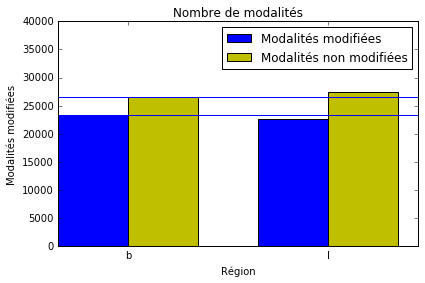

In [49]:
# Représentation graphique des différences quantitatives entre les deux méthodes (par région)

import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 2

 
# create plot
fig, ax = plt.subplots()
#figsize=(15, 6)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(index, modalites_modifiees, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Modalités modifiées')
 

rects2 = plt.bar(index + bar_width, modalites_intactes , bar_width,
                 alpha=opacity,
                 color='y',
                 label='Modalités non modifiées')

plt.ylim(0, 40000)
ax.axhline(y = modalites_modifiees[0])
ax.axhline(y = taille_données_transparence[0])

plt.xlabel('Région')
plt.ylabel('Modalités modifiées')
plt.title('Nombre de modalités')
plt.xticks(index + bar_width, 'bla')
plt.legend()
 
plt.tight_layout()
plt.show()